In [1]:
!nvidia-smi

Wed Mar  3 21:36:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0 Off |                  N/A |
| 35%   59C    P2    84W / 250W |   1126MiB / 11016MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import os 
import matplotlib.pyplot as plt
os.getcwd()
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)]) 
    except RuntimeError as e:
        print(e)

In [3]:
# Download and prepare the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

train_images = tf.cast(train_images[:,:,:,np.newaxis], tf.float32)
test_images = tf.cast(test_images[:,:,:,np.newaxis], tf.float32)

IMAGE_SIZE, IMAGE_DEPTH = 28, 1
EPOCH = 10

In [4]:
inputs_img = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))(inputs_img)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs_img, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               991360    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_hist = model.fit(train_images, train_labels, epochs=EPOCH, batch_size = 16, validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 22s 512us/sample - loss: 0.2013 - accuracy: 0.9395 - val_loss: 0.0764 - val_accuracy: 0.9778
Epoch 2/10
42000/42000 [==============================] - 18s 440us/sample - loss: 0.0794 - accuracy: 0.9765 - val_loss: 0.0427 - val_accuracy: 0.9878
Epoch 3/10
42000/42000 [==============================] - 19s 441us/sample - loss: 0.0553 - accuracy: 0.9828 - val_loss: 0.0433 - val_accuracy: 0.9877
Epoch 4/10
42000/42000 [==============================] - 18s 439us/sample - loss: 0.0431 - accuracy: 0.9865 - val_loss: 0.0522 - val_accuracy: 0.9853
Epoch 5/10
42000/42000 [==============================] - 18s 440us/sample - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.0413 - val_accuracy: 0.9883
Epoch 6/10
42000/42000 [==============================] - 18s 439us/sample - loss: 0.0276 - accuracy: 0.9913 - val_loss: 0.0421 - val_accuracy: 0.9901
Epoch 7/10
42000/42000 [====================

In [6]:
class FC_dropconnect(tf.keras.layers.Layer):
    def __init__(self, units = 32, prob = 0.5):
        super(FC_dropconnect, self).__init__()
        self.units = units
        self.relu = tf.keras.layers.ReLU()
        self.prob = prob
        
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_shape[-1], self.units), dtype="float32"),trainable=True)
        # w is a matrix with shape (input_dim, output_dim)
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value=b_init(shape=(self.units,), dtype="float32"), trainable=True)
        # b is a matrix with shape (output_dim, 1)
        
        mask_matrix = tf.Variable(tf.cast(tf.math.greater(tf.random.uniform(shape=(input_shape[-1], self.units), maxval=1), self.prob), tf.float32), trainable=False)
        self.w = self.w * mask_matrix
        
    def call(self, inputs):
        return self.relu(tf.matmul(inputs, self.w) + self.b)

In [7]:
inputs_img = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH))(inputs_img)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = FC_dropconnect(units = 128, prob = 0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model_DC = tf.keras.Model(inputs=inputs_img, outputs=outputs)
model_DC.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
fc_dropconnect (FC_dropconne (None, 128)               128       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290

In [8]:
model_DC.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

model_DC_hist = model_DC.fit(train_images, train_labels, epochs=EPOCH, batch_size = 16, validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 19s 443us/sample - loss: 0.2859 - accuracy: 0.9161 - val_loss: 0.1384 - val_accuracy: 0.9577
Epoch 2/10
42000/42000 [==============================] - 18s 433us/sample - loss: 0.1083 - accuracy: 0.9676 - val_loss: 0.1211 - val_accuracy: 0.9636
Epoch 3/10
42000/42000 [==============================] - 18s 434us/sample - loss: 0.0788 - accuracy: 0.9761 - val_loss: 0.0908 - val_accuracy: 0.9738
Epoch 4/10
42000/42000 [==============================] - 18s 433us/sample - loss: 0.0637 - accuracy: 0.9797 - val_loss: 0.0832 - val_accuracy: 0.9749
Epoch 5/10
42000/42000 [==============================] - 18s 434us/sample - loss: 0.0521 - accuracy: 0.9834 - val_loss: 0.0804 - val_accuracy: 0.9764
Epoch 6/10
42000/42000 [==============================] - 18s 434us/sample - loss: 0.0463 - accuracy: 0.9849 - val_loss: 0.0960 - val_accuracy: 0.9738
Epoch 7/10
42000/42000 [====================

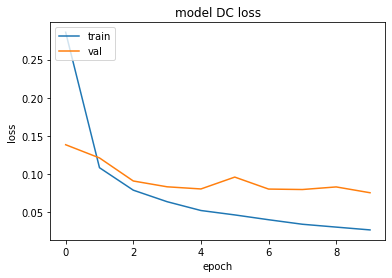

In [9]:
plt.plot(model_DC_hist.history['loss'])
plt.plot(model_DC_hist.history['val_loss'])
plt.title('model DC loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

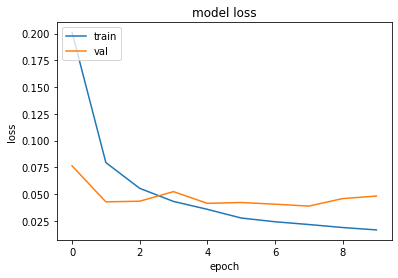

In [10]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

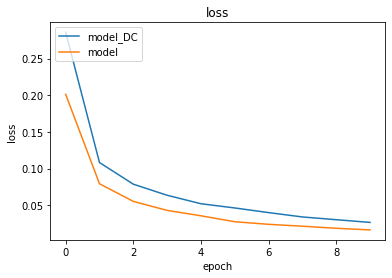

In [11]:
plt.plot(model_DC_hist.history['loss'])
plt.plot(model_hist.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model_DC', 'model'], loc='upper left')
plt.show()

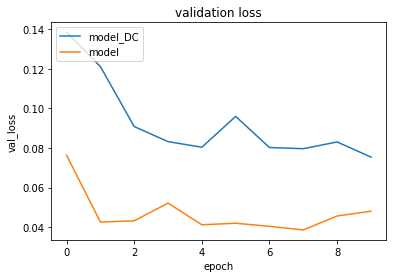

In [12]:
plt.plot(model_DC_hist.history['val_loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['model_DC', 'model'], loc='upper left')
plt.show()

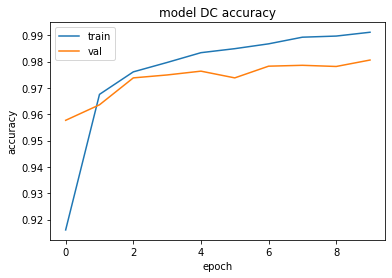

In [13]:
plt.plot(model_DC_hist.history['accuracy'])
plt.plot(model_DC_hist.history['val_accuracy'])
plt.title('model DC accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

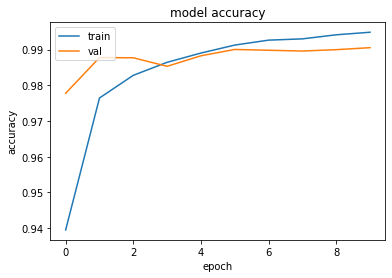

In [14]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

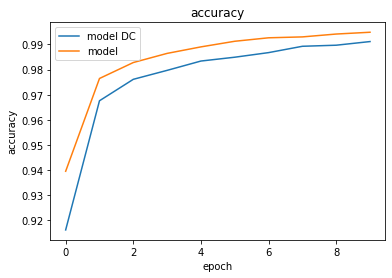

In [15]:
plt.plot(model_DC_hist.history['accuracy'])
plt.plot(model_hist.history['accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model DC', 'model'], loc='upper left')
plt.show()

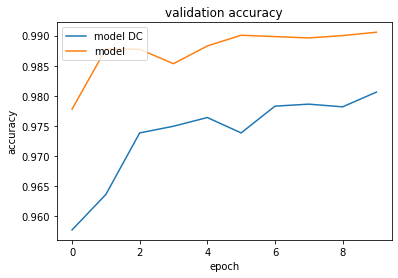

In [16]:
plt.plot(model_DC_hist.history['val_accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model DC', 'model'], loc='upper left')
plt.show()

In [21]:
accuracy = tf.keras.metrics.Accuracy()
print('testing accuracy, model {:.4f}, model drop connection {:.4f}'.format(accuracy(tf.argmax(model.predict(test_images), axis = 1), test_labels), accuracy(tf.argmax(model_DC.predict(test_images), axis = 1), test_labels)))

testing accuracy, model 0.9904, model drop connection 0.9869
